In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

2025-12-24 10:05:53.358089: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1766570766.316748   79125 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


In [2]:
import os
import gdown
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

dataset_path = os.environ.get('RCMD_DATASET_PATH', '../dataset')
print('Dataset path', dataset_path)
model_path = os.environ.get('RCMD_MODEL_PATH', '../model')
print('Model path', model_path)
log_path = os.environ.get('RCMD_LOG_PATH', '../logs')
print('Log path', log_path)

Dataset path ../dataset
Model path ../model
Log path ../logs


# Negative Sampling

지금까지 살펴본 모델은 사용자의 평점을 회귀 모델을 사용하여 예측을 하여 추천에 활용하기 위한 모델을 만들었습니다. 

평점은 아이템에 대한 직접적 피드백에 해당되는데요.

조회한 아이템 내역과 같은 **간접적 피드백(Implicite Feedback)**을 활용하는 데 꼭 필요한 **Negative Sampling**에 대해서 알아봅니다.


## 다중분류(MultiClass Classfication)

대상 클래스가 2개가 넘는 분류 문제를 말합니다.

Logit은 [0, 1]의 확률 공간을 [-∞, ∞]의 실수 공간으로 변환한 값입니다.

이진분류에서는 참(True, Positive) 두 개의 클래스이므로 Positive 확률의 Logit만 사용합니다.

왜냐하면 Positive 확률이 정해지면 Negative이에 따라 정해지기 때문입니다.

다중분류에서는 각 클래스의 Logit을 구해야 합니다. 

다중분류에서는 A가 아니면, B, C, ... 이므로 각각에 대한 확률을 고려가 필요해서요.

따라서 클래스 별로 로짓을 모델에서 출력해야 합니다.

간단한 예를 들어 보겠습니다.

Iris 데이터셋에서 붓꽃의 종류를 붓꽃의 각 부분의 사이즈로 맞추는 모델을 만들어 보겠습니다.

Iris 데이터셋에서 붓꽃의 총 종류는 3종류 입니다.

In [3]:
from sklearn.datasets import load_iris
import numpy as np

In [4]:
iris = load_iris(as_frame=True)
df_X = iris['data']
s_y = iris['target']
display(df_X.head(5))
display(s_y.head(5))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

Output에서는 3개의 로짓을 출력합니다.

**모델 구조**

```mermaid
flowchart LR
    subgraph seq[Sequential]
        subgraph i[Input]
            direction LR
            i1["sepal length<br>sepal width<br/>petal length<br/>petal width"]
        end
        direction LR
        subgraph d1["H1:Dense"]
            p1["unit=4<br/>activation: ReLU"]
        end
        subgraph o["Output:Dense"]
            p2["unit=3"]
        end
    end
    prob((Logit))
    i-->|Nx4|d1
    d1-->|Nx4|o
    o-->|Nx3|prob

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F
    
    class d1 layer
    class o layer
    class p1 trainable
    class p2 trainable
```

로짓에서 확률을 구하고자 할 때에는 Softmax를 사용합니다. 함수의 형태는 아래와 같습니다.

- $\Large \displaystyle Softmax(\mathbf{z}) = \frac{e^{z_i}}{\sum_{j=1}^Ke^{z_j}}$ 

In [5]:
from sklearn.preprocessing import StandardScaler
# Tensorflow 데이터셋을 만듭니다. 
# Iris Dataset의 입력 변수를 표준화 합니다.
std_scaler = StandardScaler()
std_scaler.fit(df_X.values)
ds_iris = tf.data.Dataset.from_tensor_slices(
    (std_scaler.transform(df_X.values), s_y)
)

# 따로 Model을 상속받지 않고, tf.keras.models.Sequential(순차적 모델)을 정의합니다.
# 이용하여 모델을 정의해봅니다. 간단한 네트워크를 정의하기에 유용합니다.
# tf.keras.models
clf_iris = tf.keras.models.Sequential(name = 'iris')
# 입력 레이어를 추가합니다. 4개(sepal length (cm), sepal width (cm), petal length (cm), petal width (cm))
clf_iris.add(
    tf.keras.layers.Input(shape = (4, ), name = 'input')
)
# Unit의 수가 4개인 은닉층을 추가합니다. activation은 relu를 씁니다.
clf_iris.add(
    tf.keras.layers.Dense(4, activation = 'relu', kernel_initializer = 'he_uniform')
)
# Logit의 수가 3개(대상 변수의 Class가 3개)인 Layer를 추가합니다.
clf_iris.add(
    tf.keras.layers.Dense(3, kernel_initializer = 'glorot_uniform')
)

# 확률을 출력하고자 한다면 Softmax를 추가하고, compile단계에서 loss에 tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)로 설정합니다.
# clf_iris.add(tf.keras.layers.Softmax())
# Sparse
# 0, 1, 2
# Dense
# [1, 0, 0],
# [0, 1, 0],
# [0, 0, 1],
clf_iris.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # 분류에서 사용하는 대상 변수의 확률과 모델에서 주는 대상 변수의 확률간의 차이를 손실함수로 합니다.
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
clf_iris.fit(ds_iris.shuffle(100).batch(8), epochs=20)

Epoch 1/20


2025-12-24 10:06:08.871364: I external/local_xla/xla/service/service.cc:163] XLA service 0x728c60007c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-24 10:06:08.871400: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-12-24 10:06:08.925655: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-24 10:06:09.081948: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7406 - sparse_categorical_accuracy: 0.6016

I0000 00:00:1766570769.446753   79185 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5968 - sparse_categorical_accuracy: 0.6800
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4316 - sparse_categorical_accuracy: 0.8267
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3423 - sparse_categorical_accuracy: 0.8800
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2760 - sparse_categorical_accuracy: 0.9200
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2391 - sparse_categorical_accuracy: 0.9333
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2051 - sparse_categorical_accuracy: 0.9467
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1850 - sparse_categorical_accuracy: 0.9467
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1701 - sparse_categorical_accuracy: 0.9467
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1493 - sparse_categorical_accuracy: 0.9533
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1388 - sparse_categori

In [6]:
from sklearn.metrics import accuracy_score
# df_X를 입력으로 예측합니다. 
accuracy_score(
    s_y,
    np.argmax(clf_iris.predict(
        tf.constant(std_scaler.transform(df_X.values))
    ), axis = 1),
)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


0.9733333333333334

## Negative Sampling이란?

Softmax 기반의 모델에서는 모델에서 출력하는 Logit의 수는 곧 대상 클래스의 수입니다.

- 추천 문제에 있어서는 Logit의 수가 곧 아이템의 수가 됩니다. 

- 아이템의 수가 많아 수록 Logit의 수는 많아지게 됩니다. 

-  따라서 모델의 Weight(가중치)의 수도 아이템의 수가 늘어남에 따라 모델의 크기가 커집니다.

- 이에 따른 연산 시간이 늘어 나고, 연산 자원 또한 많이 필요하게 됩니다.

**해결책**

리소스의 문제를 해결하기 위해 선별의 대상을 전체 아이템을 사용하지 않고

정답 클래스(Positive Class)를 제외한 비정답 클래스(Negative Classes)의 일부만을 선택해서 분류하게 합니다.

비정답 클래스의 일부만을 뽑아내는 기법을 **Negative Sampling**이라고 합니다.

Iris와 같이 모든 클래스를 가지고 Logit을 구성하는 모델을 사용해봅니다.

user id가 평점을 한 item id를 맞추는 모델을 만듭니다.

In [7]:
import pickle
import pandas as pd

# MovieLens 100K를 데이터셋을 불러옵니다.
df_ratings = pd.read_csv(os.path.join(dataset_path, 'ratings_100k.csv'))
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv(os.path.join(dataset_path, 'users_100k.csv'), index_col='user id')
df_movie = pd.read_csv(os.path.join(dataset_path, 'movies_100k.csv'), index_col='movie id')

In [8]:
n_user = df_ratings['user id'].nunique()
n_user

943

In [9]:
df_ratings['user id'].agg(['min', 'max'])

min      1
max    943
Name: user id, dtype: int64

In [10]:
n_item = df_ratings['item id'].nunique()
n_item

1682

In [11]:
ds_10k = tf.data.Dataset.from_tensor_slices(
    (df_ratings['user id'], df_ratings['item id'] - 1)
)
for X, y in ds_10k.batch(32).take(1):
    print(X, y)

tf.Tensor(
[196 186  22 244 166 298 115 253 305   6  62 286 200 210 224 303 122 194
 291 234 119 167 299 291 308  95  38 102  63 160  50 301], shape=(32,), dtype=int64) tf.Tensor(
[ 241  301  376   50  345  473  264  464  450   85  256 1013  221   39
   28  784  386  273 1041 1183  391  485  143  117    0  545   94  767
  276  233  245   97], shape=(32,), dtype=int64)


2025-12-24 10:06:12.245992: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**모델 구조**

```mermaid
flowchart LR
    subgraph i[Input]
        direction LR
        i1["user id"]
    end

    subgraph seq[Sequential]
        direction LR
        subgraph emb["user_emb:Embedding"]
            p1["input_dim: 943(user id수),<br/> output_dim=16"]
        end
        fl["Flatten"]
        subgraph o["Output:Dense"]
            p2["unit=item id수"]
        end
    end
    prob((Logit))
    i-->|Nx1|emb
    emb-->|Nx1x16|fl
    fl-->|Nx16|o
    o-->|"Nx1682(item id수)"|prob

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class emb layer
    class fl layer
    class o layer
    class p1 trainable
    class p2 trainable
```

In [12]:
# 입력변수는 user id, 대상 변수는 item id인 tensorflow 데이터셋을 만듭니다.
ds_10k = tf.data.Dataset.from_tensor_slices(
    (df_ratings['user id'], df_ratings['item id'] - 1)
)

clf_rating = tf.keras.models.Sequential(name='user')
# 입력 변수의 수가 1인 이름이 user id인 입력층을 추가합니다. N x 1
clf_rating.add(
    tf.keras.layers.Input(shape = (1, ), name = 'user id')
)
# 출력 임베딩 사이즈가 16인 임베딩 층을 추가합니다. N x 1 x 16
clf_rating.add(
    tf.keras.layers.Embedding(df_ratings['user id'].nunique() + 1,  16)
)
# 2차원으로 Tensor로 만듭니다. N x 16
clf_rating.add(
    tf.keras.layers.Flatten()
)
# 출력수가 n_item인 Logit을 출력하게 되는 밀도 레이어를 추가합니다. N x n_item
clf_rating.add(tf.keras.layers.Dense(n_item)) 

In [13]:
clf_rating.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
clf_rating.fit(ds_10k.shuffle(100000).batch(256), epochs=30)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 7.2134 - sparse_categorical_accuracy: 0.0049
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7641 - sparse_categorical_accuracy: 0.0058
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6953 - sparse_categorical_accuracy: 0.0059
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6625 - sparse_categorical_accuracy: 0.0063
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6165 - sparse_categorical_accuracy: 0.0071
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5513 - sparse_categorical_accuracy: 0.0072
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4816 - sparse_categorical_accuracy: 0.0070
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.4227 - sparse_categorical_accuracy: 0.0073
Epoch 9/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.3779 - sparse_categorical_accuracy: 0.0074
Epoch 10/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - 

```
clf_rating.add(tf.keras.layers.Embedding(n_user + 1, 16)) # N × 16
clf_rating.add(tf.keras.layers.Dense(n_item)) # N x n_item
```

대상 아이템의 수준의 수가 커지면 출력 Logit수도 그 만큼 증가하게 됩니다. 

따라서, 학습과 서비스에 필요한 리소스드 증가하게 됩니다.

대상 변수의 클래수가 1,500개 정도는 까지는 눈에 띄지 않지만,

Item이 많아질 수록 현저하게 성능이 떨어집니다.

## Negative Sampling의 방법

위의 MovieLens 10K로 구성한 네트워크 구조를 가지고 설명을 드립니다.

Dense Layer의 Weight Matrix Size는 16(출력 레이어에 입력되는 변수의수) x n_movie(대상 클레스 수) 입니다. 

Dense Layer의 Weight Matrix를 W 라하고, 

(여기서는 Bias는 고려하지 않습니다.)

- I: Dense Layer에 입력 행렬 (N × 16)  N: 배치의 사이즈

- O: 출력 행렬 (N × n_movie)  n_movie: 영화의 종류수

- O = I × W

- W: 가중치 행렬 (16 x n_movie)

O의 i열은 i 번째 영화의 Logit 이고, W의 열벡터와 입력 Matrix각의 곱으로 나온 값입니다. 

W의 열벡터 중에서 Logit을 구하고자 하는 영화의 벡터만을 취하여 입력과 행렬곱을 하면 됩니다.

W의 각각 열벡터는 해당 Item의 임베딩이라고 할 수 있습니다.

Embedding Layer를 사용하여 샘플링한 아이템들만을 뽑아 출력층의 가중치를 만들어 행렬곱을 

통해 로짓을 만듭니다.

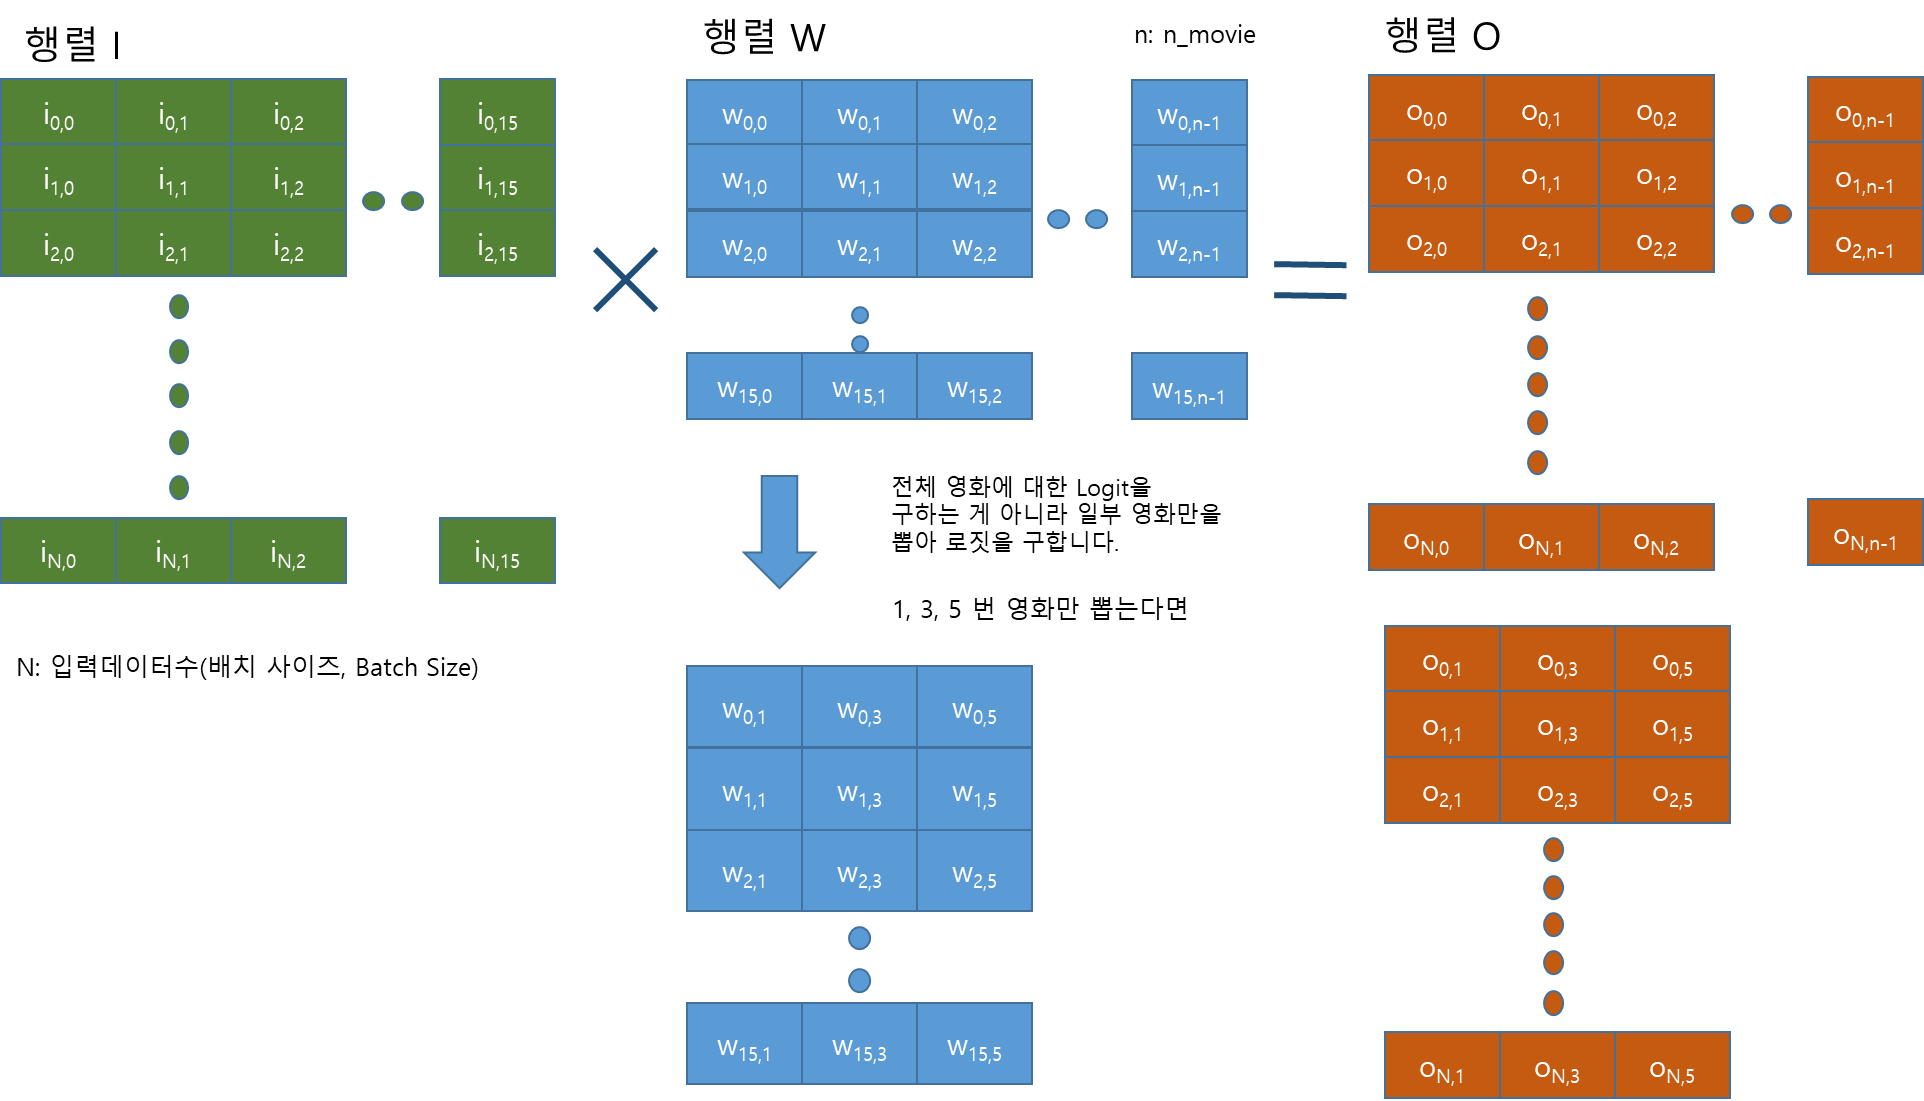

### Negative Sampling의 효율화

거대 데이터는 연산 장치의 메모리에 데이터를 모두 탑재하지 못하여 데이터를 동일 크기로 나누어 학습을 합니다.

배치 단위의 학습 과정에서 Negative Sampling을 효율화할 수 있습니다.

예를 들어,  

movie_ids가 [1, 2, 3, 4, ..., 10]

인 데이터셋이 있다면

|user_id|movie_id|
|-|-|
|1|1|
|2|2|
|3|4|
|4|5| 
|7|10|
|5|8|
....

배치(Batch)의 크기를 4개로 한다면, 

첫 번째 배치(Batch)에 해당하는 데이터는

|user_id|movie_id|
|-|-|
|1|1|
|2|2|
|3|4|
|4|5|

입니다. 

Negative Sampling을 행 단위로 본다면

첫 번째 행에서의 Negative 클래스는 1을 제외한 2, 3, 4, ..., 10 중에서

두 번째 행에서의 Negative 클래스는 2를 제외한 1, 3, 4, ..., 10 중에서 
...

각 행 별로 Negative Class를 선정해서 Logit을 만들게 되는데요. 샘플링 비용이 만만치 않습니다.

행 단위로 하는게 아니라 **배치(Batch) 단위**로 Negative Sampling을 하면 연산이 비약적으로 간단해 집니다.

각각 행에서 정답인 클래스는 무조건 Logit을 만들어야 합니다. 

1, 2, 4, 5 클래스만을 가지로 로짓행렬을 구성합니다.

이렇게 된다면  Negative Class는 

첫 번째 행에서 Negative Class는 2, 4, 5

두 번째 행에서 Negative Class는 1, 4, 5

...

으로 자연스럽게 Negative Class가 구성이 되게 됩니다.

그리고 로짓을 구하는 연산은 (1, 2, 3, 4)번 사용자의 벡터를 모은 행렬(사용자 행렬)과

(1, 2, 4, 5) 영화의 벡터를 모은 행렬(영화 행렬)의 행렬 곱으로 4x4의 로짓 행렬으 만들 수 있게 됩니다.

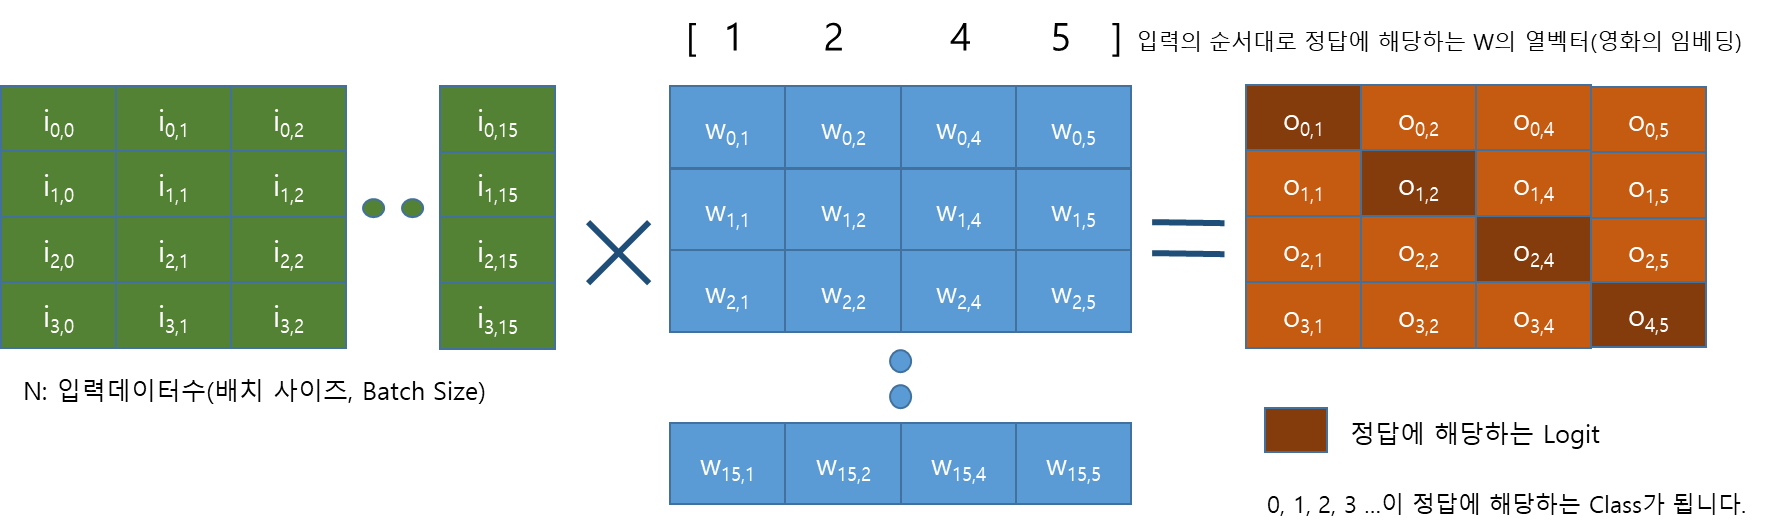

- Negative Sampling을 통한 예측 모델은 Matrix Factorization 처럼 사용자와 아이템의 벡터를 기반으로 하고 있습니다.

- Matrix Factozation은 사용자와 아이템 각각의 벡터의 내적으로 평점을 예측 하지만, Negative Sampling은 행렬곱을 통해 Logit을 만들어 냅니다.

- 그리고 단일 사용자 관점에서 아이템의 선정의 문제는 Matrix Factorization과 동일하게 Dot Product 기반의 Ranking의 문제로 풀어 낼 수 있습니다.

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 35
  }
}}%%
flowchart LR
    subgraph I[inputs]
        uId(userId)
        mId(movieId)
    end
    subgraph mm["<div style='white-space:nowrap;'>NSModel(user_ids, movie_ids, rank)</div>"]
        subgraph u_m["user_model:EmbModel"]
            sz1["ids: user_ids, size:rank"]
        end
        subgraph m_m["movie_model:EmbModel"]
            sz2["<div style='white-space:nowrap;'>ids: movie_ids, size:rank</div>"]
        end
        Rw("matmul(transpose_b=True)")
    end
    
    output((Logit))
    uId-->|N|u_m
    mId-->|N|m_m
    u_m-->|Nxrank|Rw
    m_m-->|Nxrank|Rw
    Rw-->|NxN|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F
    
    class u_m layer
    class m_m layer
    class sz1 trainable
    class sz2 trainable
```

In [14]:
class NSModel(tf.keras.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        
    def call(self, x):
        I = user_model(x['user id'])
        W_prime_t = movie_model(x['movie id'])
        Logit = tf.matmul(I, W_prime_t, transpose_b = True)
        return Logit

## MovieLens 10K에 적용

In [15]:
# Matrix Factorization 3까지 만들었던 Model 들이 들어가 있습니다.
import rcmd

tf.keras.backend.clear_session()
user_model = rcmd.EmbModel(df_ratings['user id'].unique(), 16)
movie_model = rcmd.EmbModel(df_ratings['item id'].unique(), 16)
clf_ns = NSModel(user_model, movie_model)

# 동작을 확인하기 위해 작은 사이즈의 구분단위로 구성합니다. 데이터셋을 구성해봅니다.
N = 4

ds_10k_ns = tf.data.Dataset.from_tensor_slices((
    {
        'user id': df_ratings['user id'], 
        'movie id': df_ratings['item id']
    }, 
    np.arange(0, len(df_ratings)) % N # Batch에서 첫번째는 0, 두번째는 1 순차적으로 정답이 됩니다.
)).batch(N)

In [16]:
np.arange(0, len(df_ratings))[:30] % 4

array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1])

In [17]:
for i in ds_10k_ns.take(1):
    print('user id', i[0]['user id'])
    print('movie id', i[0]['movie id'])
    print('target', i[1])
    print(clf_ns(i[0]))

user id tf.Tensor([196 186  22 244], shape=(4,), dtype=int64)
movie id tf.Tensor([242 302 377  51], shape=(4,), dtype=int64)
target tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor(
[[-0.00283425  0.00356275 -0.00587093  0.0006896 ]
 [ 0.00144569 -0.00194896  0.00469197 -0.00288134]
 [-0.00100203 -0.00137707 -0.00098808  0.00267774]
 [ 0.0054303   0.00326686 -0.00080892  0.00499029]], shape=(4, 4), dtype=float32)


2025-12-24 10:07:03.971173: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
# Batch의 크기는 128입니다.
N = 128
# 데이터셋을 구성해봅니다. 
ds_10k_ns = tf.data.Dataset.from_tensor_slices((
    {
        'user id': df_ratings['user id'], 
        'movie id': df_ratings['item id']
    }, 
    np.arange(0, len(df_ratings)) % N
)).batch(N)

In [19]:
clf_ns.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
clf_ns.fit(ds_10k_ns, epochs=30)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.8399 - sparse_categorical_accuracy: 0.0102
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4.7017 - sparse_categorical_accuracy: 0.0191
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 4.5685 - sparse_categorical_accuracy: 0.0242
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 4.4976 - sparse_categorical_accuracy: 0.0299
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 4.4504 - sparse_categorical_accuracy: 0.0342
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 4.4140 - sparse_categorical_accuracy: 0.0379
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 4.3844 - sparse_categorical_accuracy: 0.0404
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4.3597 - sparse_categorical_accuracy: 0.0430
Epoch 9/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 4.3387 - sparse_categorical_accuracy: 0.0454
Epoch 10/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - 

사용자가 선택한 아이템을 맞추는 분류기 기반의 모델, 즉 아이템에 대한 로짓을 출력하는 모델 또한

동일한 Rank의 출력을 하는 Item과 User의 Matrix Factorization 모델의 다른 형태입니다.

앞에서 다루었던 모델에서 User와 Item을 동일하고 최종 출력물을 만들어주는 레이어에 Negative Sampling을 

적용해주면 됩니다.

In [20]:
del clf_ns

# 사용자가 평점을 남긴 영화를 예측하는 모델 만들기

MovieLen25m에 Negative Sampling을 활용하여 평점을 남긴 모델을 만듭니다.

평점을 예측할 때 만들었던, User 모델과 Movie 모델을 그대로 활용할 수 있습니다.

**UserHistModel2**: 사용자의 이전 시청 이력들까지 반영한 모델

**MovieInfoModel**: 영화의 줄거리, 장르, 시리즈 정보를 포함한 모델

## MovieLen32m 데이터

In [21]:
from tqdm import tqdm

# Matrix Factorization 3에서 MovieLens25m을 처리했던 함수들이 들어가 있습니다.
import movielens32m

from IPython.display import clear_output

# MovieLens 25m을 불러 옵니다.
m32m = movielens32m.load_dataset(dataset_path)
# 평점 이력
df_ratings = m32m['ratings']
# 시리즈(collection) 정보
s_series = m32m['series']
# 장르 정보
s_genre = m32m['genre']
# 영화 메타 데이터
df_movie = m32m['movie']
# 영화의 장르, 시리즈, OpenAI에서 Embedding API를 통해 추출한 영화 줄거리 Embedding을 한데 모은 데이터프레임
movieinfo = m32m['movieinfo']

In [22]:
# 사용자별로 영화 시청이력을 모아 옵니다.
df_user_hist = df_ratings.sort_values('date').groupby('userId').agg(list).map(np.array)
df_user_hist.head()

,movieId,rating,date,ts
userId,,,,
1,"[2997, 2966, 2890, 3078, 2882, 541, 838, 1136,...","[4.0, 1.0, 4.0, 2.0, 1.0, 5.0, 5.0, 1.0, 5.0, ...","[1999-11-21 23:27:26, 1999-11-21 23:27:26, 199...","[943226846000000000, 943226846000000000, 94322..."
2,"[592, 296, 380, 344, 153, 588, 349, 318, 231, ...","[4.0, 1.0, 5.0, 1.0, 3.0, 5.0, 3.0, 5.0, 2.0, ...","[1996-07-03 19:46:41, 1996-07-03 19:46:42, 199...","[836423201000000000, 836423202000000000, 83642..."
3,"[2012, 466, 2268, 168, 1544, 4306, 1485, 2617,...","[3.0, 1.0, 4.0, 3.5, 4.0, 3.5, 4.0, 4.0, 3.5, ...","[2004-05-13 21:39:14, 2004-05-13 21:39:22, 200...","[1084484354000000000, 1084484362000000000, 108..."
4,"[1210, 1833, 2745, 1272, 2115, 1327, 2826, 268...","[3.0, 2.0, 3.0, 4.0, 5.0, 3.0, 2.0, 3.0, 2.0, ...","[2000-06-08 17:27:14, 2000-06-08 17:27:14, 200...","[960485234000000000, 960485234000000000, 96048..."
5,"[592, 150, 590, 380, 296, 349, 344, 165, 588, ...","[4.0, 3.0, 3.0, 5.0, 1.0, 4.0, 3.0, 4.0, 3.0, ...","[1996-08-23 01:31:53, 1996-08-23 01:31:54, 199...","[840763913000000000, 840763914000000000, 84076..."


In [23]:
df_seq = pd.concat([
    df_ratings['userId'].map({k:v for k, v in zip(df_user_hist.index, range(len(df_user_hist)))}).rename('offset'), 
    df_ratings.groupby('userId')['movieId'].transform(lambda x: np.arange(len(x))).rename('seq'),
    df_ratings['date'].dt.date
], axis=1)
df_seq

,offset,seq,date
0,0,0,1999-12-03
1,0,1,1999-12-03
2,0,2,1999-11-22
3,0,3,1999-12-03
4,0,4,1999-11-22
...,...,...,...
32000199,200947,231,2011-01-07
32000200,200947,232,2010-10-16
32000201,200947,233,2011-01-07
32000202,200947,234,2012-10-16


In [24]:
df_train = df_seq.loc[df_ratings['date'] < '2022-10-13']
df_test = df_seq.loc[df_ratings['date'] >= '2022-10-13']
df_test = df_test.groupby(df_test['date']).sample(frac = 1) # 사용자 순으로 되어 있습니다. 일자별로 랜덤하게 섞이게 하여 예측시 왜곡을 최소화합니다.
len(df_train) / len(df_ratings), len(df_test) / len(df_ratings)

(0.9690947907707088, 0.030905209229291162)

In [25]:
df_test

,offset,seq,date
5786463,36144,216,2022-10-13
5786831,36144,584,2022-10-13
14715116,92177,288,2022-10-13
704484,4601,14,2022-10-13
14456018,90461,287,2022-10-13
...,...,...,...
29212692,183102,7,2023-10-13
29212705,183102,20,2023-10-13
8142467,50990,478,2023-10-13
27270644,171228,1450,2023-10-13


In [26]:
df_rating_train = df_ratings.loc[df_ratings['date'] < '2022-10-13']
df_rating_test = df_ratings.loc[df_test.index]

rating_train_mean = df_rating_train['rating'].astype('float64').mean()
ts_mean = df_rating_train['ts'].mean().astype('int64')
s_userCnt = df_rating_train['userId'].value_counts()
s_movieCnt = df_rating_train['movieId'].value_counts()

In [27]:
user_bins = [0, 1, 150, 500, 1000, np.inf]
s_user_type = pd.cut(
   df_rating_test['userId'].map(df_rating_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
).values
s_user_type.value_counts()

movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
s_movie_type = pd.cut(
    df_rating_test['movieId'].map(df_rating_train['movieId'].value_counts()).fillna(0), bins=movie_bins, right=False
).values
s_movie_type.value_counts()

[0.0, 1.0)            39603
[1.0, 100.0)          77940
[100.0, 1000.0)      121152
[1000.0, 5000.0)     204978
[5000.0, 10000.0)    132723
[10000.0, inf)       412577
Name: count, dtype: int64

In [28]:
s_movie_ts_mean = df_ratings.groupby(['movieId'])['ts'].mean().astype('int64')
del df_rating_train, df_rating_test, df_ratings

## NSModel2

**UserHistModel2**와 **MovieInfoModel**로 Negative Sampling을 활용하여 사용자가 평가한 영화를 맞추는 모델을 학습하기 위한 모델을 만듭니다.

### UserHistModelNS

평점 유무만 제공되는 상황이라고 생각을 하고 prev_ratings는 제외합니다.

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 30
  }
}}%%
flowchart LR
    subgraph I[Inputs]
        uId(userId)
        mId(prev_movieIds)
        pts(prev_ts)
    end
    subgraph mm["<div style='white-space:nowrap;'>UserHistModel2(user_ids, user_emb_size, movie_model, output_size, hidden_units, l2=0, rnn, hist_cnt)</div>"]
        subgraph u_m["user_model:EmbModel"]
            sz1["ids: user_ids, size:user_emb_size"]
        end
        m_m["movie_model:<br/>MovieInfoModel"]

        
        subgraph cc[Concatenate]
            p["<div style='white-space:nowrap;'>axis=-1<br/>M=user_emb_size+rnn['unit']</div>"]
        end

        subgraph agg[RNN]
            p3["<div style='white-space:nowrap;'>rnn=rnn['type']<br/>unit=rnn['unit']</div"]
        end

        subgraph hls[Hidden Layers]
            direction TB
            subgraph h1["H_1:Dense"]
                us1["unit_size: hidden_units[1]"]
            end
            hdot["..."]
            subgraph hn["H_n:Dense"]
                usn[unit_size: output_size]
            end
        end

        agg-->|"Nxrnn['unit']"|cc
    end
    
    output(User embedding)
    uId-->|N|u_m
    mId-->|Nxhist_cnt|m_m
    pts-->|Nxhist_cnt|m_m
    u_m-->|Nxuser_emb_size|cc
    m_m-->|Nxhist_cntxrank|agg
    style m_m stroke-dasharray: 5

    cc-->|"NxM"|hls
    h1-->|"Nxhidden_units[1]"|hdot
    hdot-->|"Nx..."|hn
    hls-->|Nxoutput_size|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class cc layer
    class cc2 layer
    class us1 trainable
    class usn trainable
    class h1 layer
    class hdot layer
    class hn layer
```

In [29]:
class UserHistModelNS(rcmd.UserHistModel):
    def __init__(self, user_ids, user_emb_size, movie_model, output_size, hidden_units = [], l2=0, rnn = {'type': 'lstm', 'unit': 32}, hist_cnt=8):
        super().__init__(user_ids, user_emb_size, movie_model, output_size, hidden_units, l2)
        self.rnn_ = rnn
        self.hist_cnt = hist_cnt
        if rnn is None:
            self.rnn = None
        elif rnn['type'] == "lstm":
            self.rnn = tf.keras.layers.LSTM(rnn['unit'])
        elif rnn['type'] == "gru":
            self.rnn = tf.keras.layers.GRU(rnn['unit'])
        else:
            self.rnn = None

    def build(self):
        self.user_model.build()
        user_model_shape = (None, self.user_model.output_size)
        if self.rnn is None:
            hist_model_shape = (None, self.movie_model.output_size)
        else:
            hist_model_shape = self.rnn.compute_output_shape((None, self.hist_cnt, self.movie_model.output_size))
            self.rnn.build((None, self.hist_cnt, self.movie_model.output_size))
        shape_ = self.cc.compute_output_shape([user_model_shape, hist_model_shape])
        for i in self.hidden_layers:
            i.build(shape_)
            shape_ = i.compute_output_shape(shape_)
        self.o.build(shape_)
    
    def call(self, x, prev_movieIds, prev_ts, training=False):
        hist_vec = self.movie_model(prev_movieIds, prev_ts, training=training)
        if self.rnn != None:
            hist_vec = self.rnn(hist_vec) # N×32
        else:
            # rnn을 사용하지 않는 다면 평균을 사용합니다. N×(rank + 1)
            hist_vec =  tf.reduce_mean(hist_vec, axis = -2) 
        x = self.cc([
            self.user_model(x, training=training), 
            hist_vec
        ])
        for i in self.hidden_layers:
            x = i(x)
        return self.o(x)


**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 35
  }
}}%%
flowchart LR
    subgraph Ips[Inputs]
        direction LR
        uId(userId)
        mId(movieId)
        pmId(prev_movieIds)
        pts(prev_ts)
        ts(ts)
    end
    subgraph mm["<div style='white-space:nowrap;'>NSModel2(user_ids, user_emb_size, user_hidden_units, rnn, hist_cnt, movieinfo, movie_ids, movie_emb_config, movie_hidden_units, rank)</div>"]
        direction LR
        subgraph u_m["user_model:UserHistModel2"]
            sz1["<div style='text-align: left;'>user_ids, user_emb_size, movie_model, rank,<br/>hidden_units, rnn, hist_cnt</div>"]
        end
        subgraph m_m["movie_model:MovieInfoModel"]
            sz2["<div style='white-space:nowrap;'> movieinfo, movie_ids, movie_emb_config,<br/> movie_hidden_units, rank</div>"]
        end
        Rw("matmul(transpose_b=True)")
    end
    
    output((Logit))
    uId-->|N|u_m
    mId-->|N|m_m
    pmId-->|Nxhist_cnt|u_m
    pts-->|Nxhist_cnt|u_m
    u_m-->|"<div style='color:red'>prev_movieIds:Nxhist_cnt</div>"|m_m
    u_m-->|"<div style='color:red'>prev_ts:Nxhist_cnt</div>"|m_m
    m_m-->|"<div style='color:red'>Nxhist_cntxrank</div>"|u_m
    ts-->|N|m_m
    u_m-->|Nxrank|Rw
    m_m-->|Nxrank|Rw
    
    Rw-->|NxN|output
    

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

```

In [30]:
class NSModel2(tf.keras.Model):
    """
    RNN 기반 Matrix Factorization 모델
    
    MFModel2_2를 확장하여 여러 개의 시청 이력을 RNN으로 처리합니다.
    사용자의 최근 N개 이력을 LSTM/GRU로 학습하여 시계열 패턴을 반영합니다.
    
    구성:
    - 사용자 모델: UserHistModel2 (RNN 기반 이력 처리)
    - 영화 모델: MovieInfoModel (메타데이터 활용)
    
    공식: rating = user_hist_vector(RNN) · movie_vector
    """
    def __init__(self, 
                 user_ids, user_emb_size, user_hidden_units, rnn, hist_cnt,
                 movieinfo, movie_ids, movie_emb_config, movie_hidden_units,
                 rank
        ):
        """
        Args:
            user_ids: 사용자 ID 목록
            user_emb_size: 사용자 임베딩 크기
            user_hidden_units: 사용자 모델 히든 레이어 크기들
            rnn: RNN 설정 {'type': 'lstm'|'gru', 'unit': 크기} 또는 None
            hist_cnt: 사용할 이력 개수
            movieinfo: 영화 메타데이터
            movie_ids: 영화 ID 목록
            movie_emb_config: 영화 임베딩 설정
            movie_hidden_units: 영화 모델 히든 레이어 크기들
            rank: 최종 벡터 차원
        """
        super().__init__()
        self.user_ids = user_ids
        self.user_emb_size = user_emb_size
        self.user_hidden_units = user_hidden_units
        self.rnn = rnn
        self.hist_cnt = hist_cnt
        self.movie_ids = movie_ids
        self.movie_emb_config = movie_emb_config
        self.movie_hidden_units = movie_hidden_units
        self.rank = rank
        self.is_built = False
        
        # 영화 모델 (메타데이터 활용)
        self.movie_model = rcmd.MovieInfoModel(movieinfo, movie_ids, movie_emb_config, rank, movie_hidden_units)
        # 사용자 모델 (RNN 기반 이력 처리)
        self.user_model = UserHistModelNS(user_ids, user_emb_size, self.movie_model, rank, user_hidden_units, rnn=rnn, hist_cnt=hist_cnt)

    def build(self):
        """모델 초기화 (중복 방지)"""
        if self.is_built:
            return
        self.user_model.build()
        self.movie_model.build()
        self.is_built = True

    def call(self, x, training=False):
        """
        Logit 계산 (RNN 기반 이력 활용)
        
        Args:
            x (dict):
                - userId: 사용자 ID
                - prev_movieIds: 이전 N개 영화 ID들
                - prev_ts: 이전 N개 시청 시간들
                - movieId: 예측할 영화 ID
                - ts: 현재 시간
            training: 학습 모드 여부
            
        Returns:
            예측 평점 = user_vector(RNN) · movie_vector
        """
        I = self.user_model(
            x['userId'], 
            x['prev_movieIds'], 
            x['prev_ts'],
            training=training
        )
        W_prime = self.movie_model(x['movieId'], x['ts'], training=training)
        Logit = tf.matmul(I, W_prime, transpose_b=True) # transpose_b=True, W_prime를 Transpose를 하여 행렬곱을 합니다.
        return Logit

    def get_model_data(self):
        """모델 가중치를 딕셔너리로 반환 (저장용)"""
        return {
            'user_ids': self.user_ids,
            'user_emb_size': self.user_emb_size, 
            'user_hidden_units': list(self.user_hidden_units),
            'rnn': dict(self.rnn) if self.rnn is not None else None,
            'hist_cnt': self.hist_cnt,
            'movieinfo': self.movie_model.get_movieinfo(), 
            'movie_ids': self.movie_ids,
            'movie_emb_config': dict(self.movie_emb_config),
            'movie_hidden_units': list(self.movie_hidden_units),
            'user_model': self.user_model.get_weights(),
            'movie_model': self.movie_model.get_weights(),
            'rank': self.rank
        }

    def predict_by_userid(self, x):
        """
        한 사용자에 대한 여러 영화 평점 예측
        
        call()에서는 배치별 (사용자1, 아이템1), (사용자2, 아이템2), ... 로 쌍별 계산입니다.
        그런 상황 사용자 아이디 텐서는 아이템갯수에 대한 반복을 하게 됩니다.
        이러한 상황이 비효율 경우 최적화를 해야하며,
        하나의 사용자에게 대한 여러 아이템들의 평점을 계산합니다.
        
        Args:
            x (dict):
                - userId: 사용자 ID
                - prev_movieIds: 이전 N개 영화 ID들
                - prev_ratings: 이전 N개 평점들
                - prev_ts: 이전 N개 시청 시간들
                - movieIds: [영화 ID 리스트]
                - ts: 현재 시간
        """
        
        x_user = self.user_model(
            x['userId'],
            x['prev_movieIds'], 
            x['prev_ts'],
            training=False
        )
        # item id 행렬 user id의 임베딩을 브로드캐스트 작업시, item id 만큼 반복되는 user_emb는 매번 필요가 없는 경우 벡터와 
        # item id 만으로 매우 빠르게 되므로 빠르게 해볼 수도 있습니다.
        x_movie = self.movie_model(
            x['movieIds'], # N
            x['ts'], # N
            training=False
        )
        return tf.squeeze(
            tf.matmul(x_movie, x_user, transpose_b=True)
        )

    def get_user_vec(self, user_id, **argv):
        """특정 사용자의 임베딩 벡터 반환 (RNN 기반 이력 포함)"""
        return tf.squeeze(
            self.user_model(
                tf.constant([user_id]), tf.constant([argv['prev_movieIds']]), tf.constant([argv['prev_ts']])
            )
        )

    def get_item_vecs(self, item_ids, **argv):
        """여러 영화의 임베딩 벡터들 반환"""
        return self.movie_model(tf.constant(item_ids), tf.constant(argv['ts']))
    
    def from_model_data(model_data):
        """저장된 모델 데이터로부터 모델 복원"""
        model = NSModel2(
            model_data['user_ids'],  model_data['user_emb_size'], model_data['user_hidden_units'], model_data.get('rnn', None), model_data['hist_cnt'],
            model_data['movieinfo'], model_data['movie_ids'], model_data['movie_emb_config'], model_data['movie_hidden_units'],
            model_data['rank']
        )
        model.build()
        model.user_model.set_weights(model_data['user_model'])
        model.movie_model.set_weights(model_data['movie_model'])
        return model

### NSMeanModel

사용자별 bias는 사용자가 어떠한 Item을 선택했는 가의 관점에서는 무의미 합니다. 아이템의 bias만을 적용하는 NSMeanModel을 반듭니다.

Logit 행렬에서 movieId에 따라 bias를 지정하면 되므로, movieId에 해당하는 열에 동일한 bias가 만들어지도록 

ones_like를 통해 모든 요소가 1인 크기가 Nx1인 행력을 만들어 곱해주면, 

모든 열이 해당 영화의 bias인 행렬을 NxN 행렬을 만듭니다.

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 30
  }
}}%%
flowchart LR
    uId(userId)
    mId(movieId)
    subgraph mm["<div style='white-space:nowrap;'>NSMeanModel(movieId 리스트)</div>"]
        u_m["ones_like"]
        subgraph m_m["movie_mean:EmbModel"]
            sz2["ids: movieId 리스트, size: 1"]
        end
        Rw("matmul(transpose_b=True)")
    end
    
    output((Logit))
    uId-->|N|u_m
    mId-->|N|m_m
    u_m-->|Nx1|Rw
    m_m-->|Nx1|Rw
    Rw-->|NxN|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F
```

In [31]:
class NSMeanModel(tf.keras.Model):
    def __init__(self, movie_ids):
        """
        Parameters:
            movie_mean_mode: EmbModel
                영화 평균 모델
        """
        super().__init__()
        
        self.movie_ids = movie_ids
        self.movie_mean_model = rcmd.EmbModel(movie_ids, 1)

    def call(self, x, training = False):
        I = tf.expand_dims(tf.ones_like(x['userId'], dtype = tf.float32), axis = -1)
        W_prime = self.movie_mean_model(x['movieId'], training = training)
        Logit = tf.matmul(I, W_prime, transpose_b = True)
        return Logit

    def build(self):
        self.movie_mean_model.build()

    def get_model_data(self):
        return {
            'movie_ids': self.movie_ids,
            'movie_mean_model': self.movie_mean_model.get_weights()
        }

    def from_model_data(model_data):
        model = NSMeanModel(
            model_data['movie_ids']
        )
        model.build()
        model.movie_mean_model.set_weights(model_data['movie_mean_model'])
        return model
    
    def get_user_vec(self, user_id, **argv):
        return tf.constant([1.0])

    def get_item_vecs(self, item_ids, **argv):
        return self.movie_mean_model(
            tf.constant(item_ids)
        )

In [32]:
ns_model2 = NSModel2(
    s_userCnt.loc[s_userCnt >= 150].index.values, 32, [64], {'type': 'lstm', 'unit': 32}, 2,
    movieinfo, s_movieCnt.loc[s_movieCnt >= 100].index.values, {'movie': 32, 'collection': 8}, [64],
    rank = 32
)
test_input = {
    'userId': tf.constant([1, 2]), 'movieId': tf.constant([3, 4]), 'ts': tf.constant([0, 0], dtype=tf.int64),
    'prev_movieIds': tf.constant([[1, 2], [3, 4]]), 'prev_ratings': tf.constant([[3.0, 4.0], [5.0, 3]]),
    'prev_ts': tf.constant([[1, 2], [3, 4]], dtype = tf.int64)
}

In [33]:
ns_model2(test_input)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.01857834, -0.02380554],
       [-0.01922808, -0.02331046]], dtype=float32)>

In [34]:
ns_mean_model = NSMeanModel(
    s_movieCnt.loc[s_movieCnt > 1].index.values
)
ns_mean_model(test_input)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.02559767, -0.00020163],
       [ 0.02559767, -0.00020163]], dtype=float32)>

In [35]:
a_model = rcmd.AdditiveModel([ns_model2, ns_mean_model])
a_model(test_input)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.00701932, -0.02400717],
       [ 0.00636958, -0.02351209]], dtype=float32)>

### Metric


**Top@K Accuracy**: 예측한 가능성으로 순위를 메겼을 때 K 순위안에 실제로 선택한 아이템에 있을 확률입니다.

많은 아이템 중에서 가장 가능성이 높은 하나의 아이템를 정답으로 보는 것보다, 

여러 후보군에 정답이 포함되어 있는 것을 바라볼 때 모델의 잠재력을 파악하는 데 도움이 됩니다.

특히, 추천에는 여러 아이템을 보여 준다는 점에서 단일 정답만을 고려하지 않고, 여러 후보군에서

정답이 있을 여부를 파악하는 데 도움이 됩니다.

In [36]:
# TopK를 구하는 예제를 들어 봅니다.
# 출력된 로짓과 정답 클래스가 아래와 같다고 가정합니다.
logit = np.array([
    [2, 1, 3],
    [1, 5, 4],
    [5, 4, 1]
])
y = np.arange(0, 3)
logit, y

(array([[2, 1, 3],
        [1, 5, 4],
        [5, 4, 1]]),
 array([0, 1, 2]))

In [37]:
np.argsort(-logit)

array([[2, 0, 1],
       [1, 2, 0],
       [0, 1, 2]])

In [38]:
# 정답이 위치하게 되는 인덱스에 True가 있게 됩니다. 
# True가 첫번째 컬럼에 있다면 첫번째로 가능성이 높은 것으로 예상한 것이 정답이고, 
# True가 두번째 컬럼에 있다면 두번째로 가능성이 높은 것으로 예상한 것이 정답이 됩니다.
(np.argsort(-logit) == np.expand_dims(y, axis=-1))

array([[False,  True, False],
       [ True, False, False],
       [False, False,  True]])

In [39]:
(
    np.sum((np.argsort(-logit) == np.expand_dims(y, axis=-1))[:1]) / 3, # Top@1
    np.sum((np.argsort(-logit) == np.expand_dims(y, axis=-1))[:2]) / 3, # Top@2
    np.sum((np.argsort(-logit) == np.expand_dims(y, axis=-1))[:3]) / 3  # Top@3
)

(np.float64(0.3333333333333333),
 np.float64(0.6666666666666666),
 np.float64(1.0))

In [40]:
# 평점을 남길 가능상 Top k개 중에 대상 영화가 있는 비율을 구합니다.
# Top@1(==Accuracy), Top@5, Top@10, Top@50, Top@100 Accuracy를 구하도록 설정합니다.
top_k = [1, 5, 10, 50, 100]

### 학습 루틴

- 동일한 배치(Batch) 안에서 각 행의 사용자가 평가한 영화를 맞추는 과정은 시점과 논리적 상관이 있습니다.

> 동일 배치(Batch)에서 각 행의 평점 시점이 영화의 개봉 시점 보다 이전인 것은 상황상 유의미 하지 않습니다.

- 이러한 논리적 모순을 최대한 방지하기 위하여 최대한 동일한 일자의 데이터를 같은 배치에 묶이게 끔 일별로 묶어서 섞는 과정을 두었습니다. 

- 그룹핑 과정에서 일별로 정렬이 되으므로 일자를 난수로 바꾸어 그룹핑하는 과정을 두어 모델이 일자에 대해 치우치는 것을 방지했습니다.

In [41]:
def train(ns_model, hist_cnt = 8, batch_size = 1024, learning_rate=1e-3):
    metric_ce = tf.keras.metrics.Mean() 
    metric_top_k = [tf.keras.metrics.Mean() for i in top_k]

    cce = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, 
        reduction=tf.keras.losses.Reduction.SUM
    ) # Target의 값은 Dense 형태로 돼있습니다. 그래서 Categorical Crossentropy를 사용합니다.
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    @tf.function(
        input_signature = [
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # userId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # movieId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # ts: N
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_movieIds: Nxhist_cnt
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.float32), # prev_ratings: Nxhist_cnt
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_ts: Nxhist_cnt
        ]
    )
    def train_step_softmax(userId, movieId, ts, prev_movieIds, prev_ratings, prev_ts):
        with tf.GradientTape() as tape:
            logits = ns_model({
                'userId': userId, 'movieId': movieId, 'ts': ts, 'prev_movieIds': prev_movieIds, 'prev_ratings': prev_ratings, 'prev_ts': prev_ts
            }, training=True)
            loss = cce(tf.eye(tf.shape(userId)[0]), logits)
            regularization_loss = tf.reduce_sum(ns_model.losses)
            loss = loss + regularization_loss
            loss = tf.identity(loss)
        
        metrics = {
            'loss': loss,
            'regularization_loss': regularization_loss
        }
        # Top-K를 구합니다.
        # 1. 모델에서 출력한 Output(Logit)에서 사용자가 선택했을 가능성이 높은 순으로 정렬합니다. 
        # 2. 정렬한 아이템이 실제로 선정 유무를 기록합니다. 
        # 3. 정답은 첫 번째 행은 0, 그 다음은 1, ... N-1 위치에 있게됩니다.
        prd_correct = tf.cast(
            tf.argsort(-logits, axis=-1) == tf.expand_dims(tf.range(0, tf.shape(userId)[0]), axis=-1), 
            tf.float32)
        # Top_K에 해당하는 수치를 구합니다.
        # K 지점까지 봤을 때 정답이 포함되어 있을 비율을 구합니다.
        for i in top_k:
            metrics['top_{}'.format(i)] = tf.reduce_mean(tf.reduce_sum(prd_correct[:, :i], axis=1))
        variables = ns_model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return metrics
    dates = df_train['date'].unique()
    with tqdm() as pbar:
        for i in rcmd.hist_set_iter(
            df_train.groupby(
                df_train['date'].map({k: v for k, v in zip(dates, np.random.random(len(dates)))}) # 일자별로 랜덤하게 섞이도록 합니다. 쏠림 현상을 막습니다.
            ).sample(frac = 1), # 동일한 일자는 인접하여 나오도록하여, 최대한 동일한 일자 단위로 뽑히게 하여, 동일한 일자끼리의 선택 과정이 되게 합니다.
            df_user_hist, hist_cnt, batch_size, pbar, rating_mean=rating_train_mean, ts_mean=ts_mean, equal_batch_size=True
        ):
            # 사용자 / 영화 / 추출한 평가이력를 train_step_softmax에 전달합니다.
            loss = train_step_softmax(
                tf.constant(i[0], dtype=tf.int64),
                tf.constant(i[1], dtype=tf.int64),
                tf.constant(i[2], dtype=tf.int64),
                tf.constant(i[3], dtype=tf.int64),
                tf.constant(i[4], dtype=tf.float32),
                tf.constant(i[5], dtype=tf.int64),
            )
            metric_ce.update_state(loss['loss'])
            for j, m in zip(top_k, metric_top_k):
                m.update_state(loss['top_{}'.format(j)])
            # Top1, Top5를 프로그레스바에 출력합니다.
            pbar.set_description(
                "ce {:.3f}, top_1 {:.3f}, top_5 {:.3f}".format(
                    metric_ce.result().numpy(), 
                    metric_top_k[0].result().numpy(),
                    metric_top_k[1].result().numpy()
                )
            )
        
def predict_test(ns_model, batch_size):
    prds = []
    correct = np.expand_dims(np.arange(0, batch_size), axis=-1)
    with tqdm() as pbar:
        for i in rcmd.hist_set_iter(
            df_test, df_user_hist, hist_cnt, batch_size, pbar, 
            shuffle=False, n_job=1, rating_mean=rating_train_mean, ts_mean=ts_mean, equal_batch_size=False
        ):
            prd = ns_model({
                'userId': tf.constant(i[0]), 
                'movieId': tf.constant(i[1]), 
                'ts': tf.constant(i[2]), 
                'prev_movieIds': tf.constant(i[3]), 
                'prev_ratings': tf.constant(i[4]),
                'prev_ts': tf.constant(i[5])
            }).numpy()
            # 파악한 top_k에 가장 큰 지점까지의 정답 포함여부를 남깁니다.
            prds.append((np.argsort(-prd, axis=-1) == correct[:prd.shape[0]])[:, :top_k[-1]])
    return np.vstack(prds)

## ns2 모델의 학습과 검증

**모델 구성**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 40
  }
}}%%
flowchart LR
    subgraph Ips[Inputs]
        direction LR
        uId(userId)
        mId(movieId)
        ts(ts)
        pmId(prev_movieIds)
        pts(prev_ts)
    end
    subgraph AM["a_model:AdditiveModel"]
        direction LR
        subgraph mm["ns_mean_model:NSMeanModel"]
            direction LR
            param1[<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>movie_ids: 출현 빈도 1회 넘는 movieId</div></div>]
        end
        subgraph mf["ns_model2:NSModel2"]
            direction LR
            param3["<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>user_ids: 출현 빈도 150회 넘는 userId</div><br/><div style='white-space:nowrap;'>user_emb_size: 32</div><br/><div style='white-space:nowrap;'>user_hidden_units: [64]</div><br/><div style='white-space:nowrap;'>movieinfo: movieinfo</div><br/><div style='white-space:nowrap;'>movie_ids: 출현 빈도 100회 넘는 movieId</div><br/><div style='white-space:nowrap;'>movie_hidden_units: [64]</div><br/><div style='white-space:nowrap;'>output_size: 32</div><br/><div style='white-space:nowrap;'>rnn: LSTM, units:8</div></div>"]
        end
    end
    output((Logit))

    uId-->|N|AM
    mId-->|N|AM
    ts-->|N|AM
    pmId-->|Nx8|AM
    pts-->|Nx8|AM
    AM-->|N|output
```

In [42]:
model_filename = os.path.join(model_path, 'ns2.pkl')

"""
if not os.path.exists(model_filename):
    o = gdown.download("https://drive.google.com/uc?id=1PzHyS1j7_Laq0dU_q_V-4PAU63R9iBEY", quiet=False)
    os.rename(o, model_filename)
"""

if not os.path.isfile(model_filename):
    tf.keras.backend.clear_session()
    # 학습을 수행하는 루틴입니다.
    hist_cnt = 8
    batch_size = 1024
    epochs = 10
    ns_model2 = NSModel2(
        s_userCnt.loc[s_userCnt >= 150].index.values, 32, [], {'type': 'lstm', 'unit': 32}, hist_cnt,
        movieinfo, s_movieCnt.loc[s_movieCnt >= 100].index.values, {'movie': 64, 'collection': 8}, [],
        rank = 32
    )
    ns_mean_model = NSMeanModel(s_movieCnt.loc[s_movieCnt > 1].index.values)
    a_model = rcmd.AdditiveModel([ns_model2, ns_mean_model])
    
    cols = ['top_{}'.format(i) for i in top_k]
    verbose=True
    topk_epoch, topk_by_userCnt, topk_by_movieCnt = list(), list(), list()
    # epoch 반복문
    for i in range(epochs):
        train(a_model, hist_cnt, batch_size, learning_rate=5e-5)
        # epoch 마다 검증 결과를 출력해줍니다.
        if verbose:
            prds = predict_test(a_model, batch_size)
            # 주어진 top_k에 대한 성능을 종합합니다.
            df_topk = pd.DataFrame(
                np.vstack([np.sum(prds[:, :j], axis=1) for j in top_k]).T,
                columns=cols
            )
            topk_epoch.append(df_topk.mean().rename(i + 1))
            topk_by_userCnt.append(
                df_topk.groupby(s_user_type, observed=True)[cols].mean().map(
                    lambda x: '{:.4f}'.format(x)
                ).apply(lambda x: ','.join(x), axis=1).rename(i + 1)
            )
            topk_by_movieCnt.append(
                df_topk.groupby(s_movie_type, observed=True)[cols].mean().map(
                    lambda x: '{:.4f}'.format(x)
                ).apply(lambda x: ','.join(x), axis=1).rename(i + 1)
            )
            clear_output()
            display(pd.concat(topk_epoch, axis=1).T)
            display(pd.concat(topk_by_userCnt, axis=1).T)
            display(pd.concat(topk_by_movieCnt, axis=1).T)
    with open(model_filename, 'wb') as f:
        pickle.dump({
            'ns_mean_model': ns_mean_model.get_model_data(),
            'ns_model2': ns_model2.get_model_data(),
            'topk_epoch': topk_epoch,
            'topk_by_userCnt': topk_by_userCnt,
            'topk_by_movieCnt': topk_by_movieCnt
        }, f)
else:
    # 제공한 ns_model 학습 결과를 불러 옵니다.
    # ns2.pkl은 강의 데이터셋이 공유된 Google Drive상에 있습니다.
    with open(model_filename, 'rb') as f:
        ns2 = pickle.load(f)
    topk_epoch, topk_by_userCnt, topk_by_movieCnt = ns2['topk_epoch'], ns2['topk_by_userCnt'], ns2['topk_by_movieCnt']
    display(pd.concat(topk_epoch, axis=1).T)
    display(pd.concat(topk_by_userCnt, axis=1).T)
    display(pd.concat(topk_by_movieCnt, axis=1).T)
    # 모델을 재구성합니다.
    tf.keras.backend.clear_session()
    ns_mean_model = NSMeanModel.from_model_data(ns2['ns_mean_model'])
    ns_model2 = NSModel2.from_model_data(ns2['ns_model2'])
    a_model = rcmd.AdditiveModel([ns_mean_model, ns_model2])

,top_1,top_5,top_10,top_50,top_100
1,0.015683,0.065322,0.113700,0.332251,0.478438
2,0.019161,0.075740,0.127830,0.354547,0.500001
3,0.020544,0.080440,0.135630,0.368301,0.514174
4,0.021430,0.084400,0.141579,0.378133,0.523777
5,0.022186,0.086459,0.144169,0.382418,0.527079
6,0.023057,0.089210,0.147531,0.388009,0.532383
7,0.023578,0.090157,0.148926,0.390635,0.534591
8,0.024435,0.092207,0.152428,0.395672,0.539497
9,0.024577,0.092801,0.152647,0.395470,0.538531
10,0.024860,0.093771,0.154290,0.398553,0.542174


,"[0.0, 1.0)","[1.0, 150.0)","[150.0, 500.0)","[500.0, 1000.0)","[1000.0, inf)"
1,"0.0142,0.0609,0.1075,0.3256,0.4751","0.0128,0.0566,0.0982,0.2944,0.4322","0.0163,0.0672,0.1165,0.3241,0.4571","0.0207,0.0786,0.1312,0.3520,0.4880","0.0251,0.0944,0.1562,0.4005,0.5453"
2,"0.0173,0.0710,0.1219,0.3502,0.4993","0.0146,0.0629,0.1071,0.3097,0.4460","0.0198,0.0779,0.1301,0.3400,0.4759","0.0256,0.0892,0.1455,0.3698,0.5029","0.0314,0.1086,0.1717,0.4184,0.5583"
3,"0.0185,0.0757,0.1299,0.3649,0.5144","0.0163,0.0661,0.1137,0.3198,0.4560","0.0221,0.0819,0.1360,0.3537,0.4888","0.0268,0.0946,0.1526,0.3799,0.5151","0.0335,0.1150,0.1808,0.4290,0.5698"
4,"0.0191,0.0796,0.1362,0.3756,0.5249","0.0182,0.0703,0.1192,0.3284,0.4668","0.0231,0.0856,0.1405,0.3628,0.4984","0.0273,0.0988,0.1584,0.3869,0.5222","0.0358,0.1190,0.1859,0.4354,0.5738"
5,"0.0197,0.0814,0.1384,0.3796,0.5283","0.0189,0.0711,0.1194,0.3312,0.4672","0.0241,0.0870,0.1439,0.3676,0.5022","0.0283,0.1015,0.1611,0.3914,0.5240","0.0377,0.1241,0.1924,0.4421,0.5783"
6,"0.0204,0.0841,0.1416,0.3854,0.5336","0.0197,0.0736,0.1230,0.3370,0.4718","0.0250,0.0904,0.1480,0.3733,0.5075","0.0306,0.1038,0.1645,0.3973,0.5302","0.0387,0.1272,0.1959,0.4460,0.5833"
7,"0.0209,0.0849,0.1431,0.3879,0.5356","0.0201,0.0731,0.1231,0.3387,0.4726","0.0253,0.0914,0.1490,0.3754,0.5100","0.0305,0.1052,0.1654,0.3993,0.5331","0.0396,0.1294,0.1982,0.4508,0.5876"
8,"0.0218,0.0869,0.1465,0.3929,0.5405","0.0212,0.0763,0.1273,0.3426,0.4765","0.0259,0.0940,0.1517,0.3804,0.5149","0.0316,0.1070,0.1685,0.4043,0.5386","0.0405,0.1313,0.2030,0.4572,0.5925"
9,"0.0219,0.0876,0.1467,0.3927,0.5393","0.0211,0.0759,0.1267,0.3419,0.4767","0.0263,0.0940,0.1516,0.3798,0.5142","0.0313,0.1065,0.1686,0.4040,0.5382","0.0412,0.1327,0.2039,0.4578,0.5925"
10,"0.0221,0.0882,0.1480,0.3956,0.5429","0.0208,0.0770,0.1285,0.3431,0.4791","0.0266,0.0960,0.1538,0.3842,0.5183","0.0322,0.1090,0.1716,0.4080,0.5415","0.0422,0.1345,0.2069,0.4616,0.5968"


,"[0.0, 1.0)","[1.0, 100.0)","[100.0, 1000.0)","[1000.0, 5000.0)","[5000.0, 10000.0)","[10000.0, inf)"
1,"0.0225,0.0880,0.1496,0.3963,0.5288","0.0190,0.0750,0.1271,0.3522,0.4905","0.0169,0.0661,0.1138,0.3228,0.4616","0.0157,0.0645,0.1101,0.3148,0.4537","0.0147,0.0608,0.1070,0.3155,0.4612","0.0144,0.0630,0.1116,0.3392,0.4941"
2,"0.0265,0.0984,0.1604,0.4048,0.5337","0.0249,0.0858,0.1400,0.3631,0.5010","0.0215,0.0785,0.1286,0.3416,0.4763","0.0192,0.0745,0.1241,0.3360,0.4746","0.0179,0.0722,0.1219,0.3401,0.4860","0.0171,0.0726,0.1259,0.3658,0.5207"
3,"0.0281,0.1021,0.1658,0.4081,0.5384","0.0257,0.0909,0.1467,0.3732,0.5109","0.0232,0.0841,0.1372,0.3536,0.4877","0.0206,0.0793,0.1316,0.3507,0.4892","0.0194,0.0773,0.1304,0.3560,0.5040","0.0184,0.0769,0.1339,0.3805,0.5360"
4,"0.0292,0.1052,0.1701,0.4136,0.5453","0.0269,0.0955,0.1523,0.3827,0.5196","0.0245,0.0875,0.1432,0.3622,0.4968","0.0217,0.0830,0.1368,0.3598,0.4990","0.0203,0.0813,0.1361,0.3678,0.5139","0.0190,0.0811,0.1405,0.3910,0.5459"
5,"0.0290,0.1054,0.1696,0.4107,0.5415","0.0282,0.0980,0.1556,0.3847,0.5207","0.0255,0.0907,0.1466,0.3672,0.5001","0.0226,0.0852,0.1403,0.3654,0.5038","0.0207,0.0838,0.1389,0.3736,0.5182","0.0197,0.0827,0.1425,0.3950,0.5492"
6,"0.0306,0.1090,0.1735,0.4197,0.5519","0.0301,0.1012,0.1595,0.3921,0.5290","0.0262,0.0935,0.1502,0.3740,0.5074","0.0236,0.0882,0.1438,0.3717,0.5103","0.0215,0.0859,0.1420,0.3794,0.5227","0.0203,0.0854,0.1456,0.3992,0.5526"
7,"0.0303,0.1107,0.1766,0.4235,0.5526","0.0302,0.1022,0.1616,0.3933,0.5307","0.0271,0.0943,0.1515,0.3760,0.5099","0.0245,0.0897,0.1457,0.3740,0.5125","0.0219,0.0861,0.1426,0.3813,0.5255","0.0207,0.0862,0.1468,0.4025,0.5547"
8,"0.0316,0.1117,0.1802,0.4281,0.5592","0.0308,0.1043,0.1663,0.3997,0.5356","0.0283,0.0972,0.1554,0.3832,0.5169","0.0250,0.0919,0.1501,0.3798,0.5187","0.0229,0.0880,0.1457,0.3861,0.5299","0.0216,0.0881,0.1496,0.4064,0.5584"
9,"0.0325,0.1128,0.1818,0.4295,0.5601","0.0315,0.1056,0.1672,0.3999,0.5357","0.0287,0.0981,0.1560,0.3848,0.5174","0.0250,0.0929,0.1508,0.3807,0.5186","0.0233,0.0885,0.1460,0.3851,0.5292","0.0215,0.0882,0.1492,0.4052,0.5561"
10,"0.0321,0.1140,0.1824,0.4310,0.5612","0.0317,0.1068,0.1684,0.4020,0.5374","0.0292,0.0997,0.1586,0.3864,0.5195","0.0254,0.0938,0.1526,0.3836,0.5218","0.0234,0.0892,0.1477,0.3887,0.5328","0.0218,0.0891,0.1506,0.4090,0.5610"


- Negative Sampling 기반의 분류 또한 Matrix Factorization 처럼 사용자 벡터와 아이템 벡터와 Dot product 척도로 근거리의 벡터를 가져오게 하여, 추천 결과를 얻을 수 있습니다

In [43]:
import scann
scann_index = scann.scann_ops.builder(
    np.vstack([
        a_model.get_item_vecs(df_movie.index[i: i + 1024], ts = ts_mean).numpy()
        for i in range(0, len(df_movie.index), 1024)
    ]), 1000, 'dot_product'
).tree(
    num_leaves=1000, num_leaves_to_search=100, training_sample_size=100000
).score_ah(
    2, anisotropic_quantization_threshold=0.2
).reorder(1000).build()

I0000 00:00:1766571197.075079   79125 partitioner_factory_base.cc:58] Size of sampled dataset for training partition: 87510
W0000 00:00:1766571197.142413   79125 gmm_utils.cc:1026] Could not normalize centroid due to zero norm or empty or zero-weight partition.
I0000 00:00:1766571197.431520   79125 kmeans_tree_partitioner_utils.h:90] PartitionerFactory ran in 351.725602ms.


In [44]:
userId = 173979
labels, sims = scann_index.search(
    a_model.get_user_vec(
        userId,
        **df_user_hist.loc[userId].pipe(
            lambda x: {'prev_movieIds': x['movieId'][-8:], 'prev_ratings': x['rating'][-8:], 'prev_ts': x['ts'][-8:]}
        )
    )
)
df_movie.iloc[labels[:10].numpy(), :2]

,title,genres
movieId,,
141335,Siege at Red River (1954),Action|War|Western
100042,"Guns of Fort Petticoat, The (1957)",War|Western
253532,Sharpe's Waterloo (1997),Action|Adventure|War
143950,Bengal Brigade (1954),Adventure|War
206585,A Captain's Honor (1982),Drama
135899,China Venture (1953),War
123113,Springfield Rifle (1952),Action|War|Western
156663,Masterson Of Kansas (1954),Western
124877,Thunder Over the Plains (1953),Action


- NSMeanModel에서 영화별 bias를 출력합니다. 이 bias는 평가를 받게 되는 상대적 강도를 의미합니다.

In [45]:
df_movie.join(
    pd.Series(ns_mean_model.get_weights()[0][1:, 0], s_movieCnt.loc[s_movieCnt > 1].index.values, name = 'm')
).sort_values('m', ascending = False).dropna().iloc[:50]

,title,genres,release_date,m
movieId,,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War,772329600000000000,1.610322
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,666489600000000000,1.333736
318,"Shawshank Redemption, The (1994)",Crime|Drama,780278400000000000,1.190029
457,"Fugitive, The (1993)",Thriller,744595200000000000,1.119741
8169,*batteries not included (1987),Children|Comedy|Fantasy|Sci-Fi,566784000000000000,1.046489
58293,"10,000 BC (2008)",Adventure|Romance|Thriller,1203638400000000000,0.945547
225173,Soul (2020),Adventure|Animation|Children|Comedy|Fantasy,1608854400000000000,0.916863
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,779155200000000000,0.915801
2572,10 Things I Hate About You (1999),Comedy|Romance,922752000000000000,0.897510


테스트셋에서 

**첫 번째**테이블 Epoch 별 Top@1, @5, @10, @50, @100 성능 입니다.

**두 번째**테이블은 Train에 평점을 남긴 수에 따른 사용자의 Top@1, @5, @10, @50, @100 성능 입니다.

**세 번째**테이블은 Train에 평점이 남겨진 수에 따른 영화의 Top@1, @5, @10, @50, @100 성능 입니다.


### ns2_model을 테스트

In [46]:
hist_cnt = 8
prds = predict_test(a_model, 1024)
cols = ['top_{}'.format(i) for i in top_k]
df_topk = pd.DataFrame(
    np.vstack([np.sum(prds[:, :i], axis=1) for i in top_k]).T,
    index=df_test.index, columns=cols
)
# Top@K 평가입니다.
df_topk.mean()

100%|██████████| 966/966 [01:17<00:00, 12.41it/s]


top_1      0.024846
top_5      0.093717
top_10     0.154292
top_50     0.398638
top_100    0.542121
dtype: float64

In [47]:
# Train에  등장한 빈도수 별 사용자의 성능 평가 입니다.
df_topk.groupby(s_user_type, observed=True)[cols].mean()

,top_1,top_5,top_10,top_50,top_100
"[0.0, 1.0)",0.021981,0.088236,0.147961,0.395759,0.542741
"[1.0, 150.0)",0.020055,0.077170,0.128238,0.342979,0.478708
"[150.0, 500.0)",0.027381,0.095300,0.154122,0.384327,0.518780
"[500.0, 1000.0)",0.032606,0.109291,0.171391,0.406589,0.541688
"[1000.0, inf)",0.042214,0.133918,0.207226,0.461784,0.596969


In [48]:
# Train에  등장한 빈도수 별 영화의 성능 평가 입니다.
df_topk.groupby(s_movie_type, observed=True)[cols].mean()

,top_1,top_5,top_10,top_50,top_100
"[0.0, 1.0)",0.033533,0.113906,0.182486,0.431028,0.561599
"[1.0, 100.0)",0.032320,0.106531,0.168283,0.402066,0.538055
"[100.0, 1000.0)",0.029219,0.099734,0.158867,0.386820,0.519884
"[1000.0, 5000.0)",0.025144,0.093956,0.152553,0.383300,0.521773
"[5000.0, 10000.0)",0.023711,0.088598,0.147563,0.389134,0.532146
"[10000.0, inf)",0.021533,0.089120,0.150629,0.409029,0.560867


In [49]:
# Embedding Projector로 영화 Embedding을 시각화해봅니다.
from tensorboard.plugins import projector

# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir=os.path.join(log_path, 'm32m_ns2/')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
known = []
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in s_movieCnt.loc[s_movieCnt >= 100].index:
        if i in m32m['movie_info_kr']:
            f.write("{}\n".format(df_movie.loc[i, 'title']))
            known.append(i)
        
weights =  tf.Variable(
    ns_model2.movie_model(tf.constant(known), tf.constant(s_movie_ts_mean.loc[known].astype('int64'), dtype=tf.int64))
)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)
%load_ext tensorboard

In [50]:
# %tensorboard --logdir logs/m32m_ns2/ --bind_all